In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import pathlib

In [7]:
class PointCloudProcessor:
    """Класс для обработки и визуализации облаков точек"""
    
    def __init__(self, seed: int = 42):
        """Инициализация с фиксированным seed для воспроизводимости"""
        np.random.seed(seed)
        self.fig_size = (8, 8)
        
    def generate_cloud(self, num_points: int = 100000, 
                      bounds: Tuple[float, float] = (0, 100)) -> np.ndarray:
        low, high = bounds
        cloud = np.random.random((num_points, 3)) * (high - low) + low
        return cloud
    
    def store_cloud(self, points: np.ndarray, filename: str) -> None:
        """Сохранение облака точек в файл"""
        np.savetxt(filename, points, fmt='%.6f')
        print(f"Облако сохранено в {filename}")
    
    def load_cloud(self, filename: str) -> np.ndarray:
        """Загрузка облака точек из файла"""
        return np.loadtxt(filename)
    
    def visualize_3d(self, points: np.ndarray, 
                    title: str = "Облако точек",
                    marker_size: float = 0.5,
                    alpha: float = 0.6) -> None:
        fig = plt.figure(figsize=self.fig_size)
        ax = fig.add_subplot(111, projection='3d')
        
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                  s=marker_size, alpha=alpha, c=points[:, 2],
                  cmap='viridis')
        
        ax.set_xlabel('Ось X', fontsize=10)
        ax.set_ylabel('Ось Y', fontsize=10)
        ax.set_zlabel('Ось Z', fontsize=10)
        ax.set_title(title, fontsize=12)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [8]:
class CloudSampler:
    
    @staticmethod
    def stochastic_sample(points: np.ndarray, 
                         target_count: int) -> np.ndarray:
        total_points = points.shape[0]
        if target_count >= total_points:
            return points.copy()
            
        selected_indices = np.random.permutation(total_points)[:target_count]
        return points[selected_indices]
    
    @staticmethod
    def voxel_based_sample(points: np.ndarray, 
                          cell_size: float) -> np.ndarray:
        # Квантование координат
        quantized_coords = np.floor(points / cell_size).astype(int)
        
        # Использование словаря для быстрого поиска уникальных ячеек
        cell_dict = {}
        result_points = []
        
        for idx, (point, cell) in enumerate(zip(points, quantized_coords)):
            cell_key = tuple(cell)
            if cell_key not in cell_dict:
                cell_dict[cell_key] = point
                result_points.append(point)
        
        return np.array(result_points)
    
    @staticmethod
    def iterative_farthest_sample(points: np.ndarray, 
                                 sample_size: int,
                                 initial_idx: Optional[int] = None) -> np.ndarray:
        n_points = points.shape[0]
        
        if sample_size > n_points:
            raise ValueError("Размер выборки превышает количество точек")
        
        # Выбор начальной точки
        if initial_idx is None:
            initial_idx = np.random.randint(n_points)
        
        selected_indices = [initial_idx]
        selected_points = [points[initial_idx]]
        
        # Вычисление расстояний от начальной точки
        current_point = points[initial_idx]
        distances = np.sum((points - current_point) ** 2, axis=1)
        
        for _ in range(1, sample_size):
            # Выбор точки с максимальным расстоянием
            next_idx = np.argmax(distances)
            selected_indices.append(next_idx)
            selected_points.append(points[next_idx])
            
            # Обновление расстояний
            new_distances = np.sum((points - points[next_idx]) ** 2, axis=1)
            distances = np.minimum(distances, new_distances)
        
        return np.array(selected_points)

In [9]:
def benchmark_samplers(points: np.ndarray) -> dict:
    results = {}
    sampler = CloudSampler()
    
    # Тестирование случайного прореживания
    start_time = time.perf_counter()
    random_sample = sampler.stochastic_sample(points, 10000)
    results['random'] = {
        'time': time.perf_counter() - start_time,
        'points': random_sample.shape[0]
    }
    
    # Тестирование воксельного прореживания
    start_time = time.perf_counter()
    voxel_sample = sampler.voxel_based_sample(points, 8.0)
    results['voxel'] = {
        'time': time.perf_counter() - start_time,
        'points': voxel_sample.shape[0]
    }
    
    # Тестирование выборки удаленных точек
    start_time = time.perf_counter()
    farthest_sample = sampler.iterative_farthest_sample(points, 4096)
    results['farthest'] = {
        'time': time.perf_counter() - start_time,
        'points': farthest_sample.shape[0]
    }
    
    return results

Загрузка существующего облака...
Исходное облако: 100000 точек


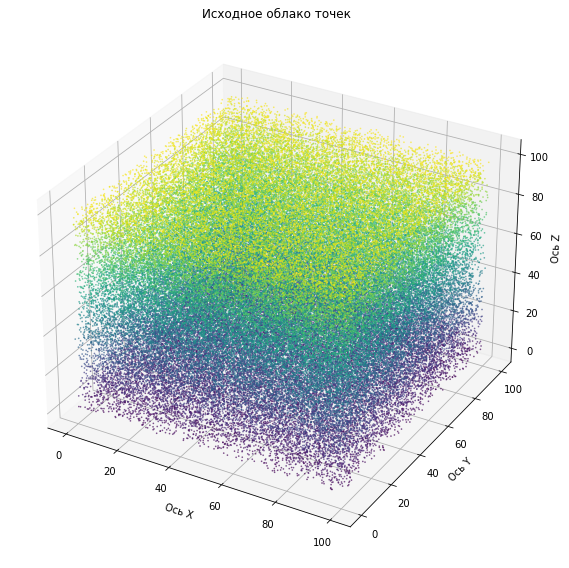


Случайное прореживание:
  Время: 0.005 сек
  Результат: 10000 точек
Облако сохранено в sampled_random.xyz


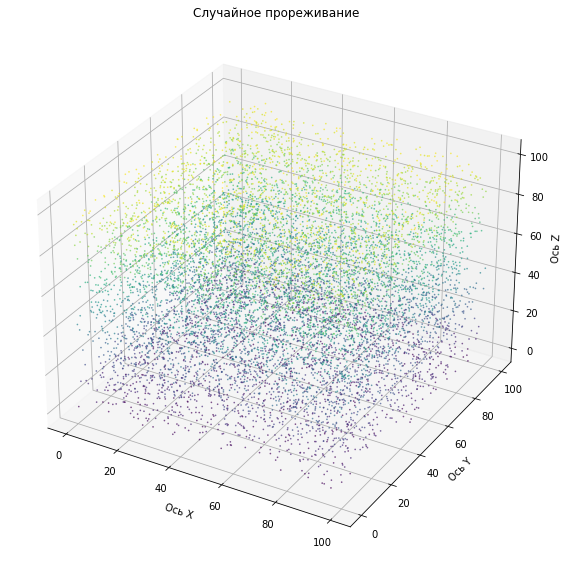


Воксельное прореживание:
  Время: 0.331 сек
  Результат: 2197 точек
Облако сохранено в sampled_voxel.xyz


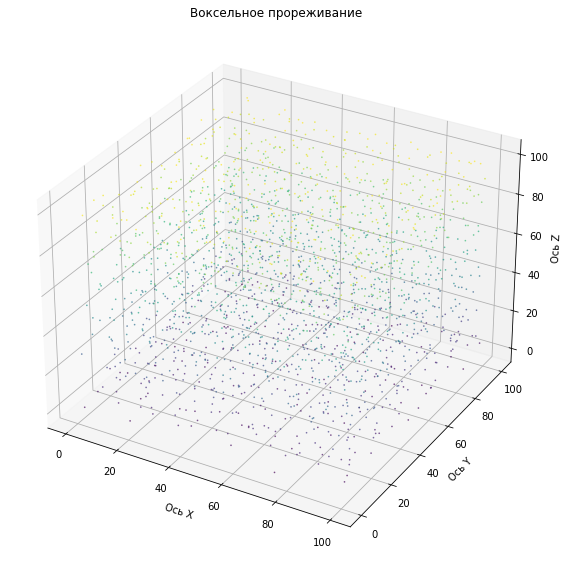


Выборка удаленных точек:
  Время: 23.081 сек
  Результат: 4096 точек
Облако сохранено в sampled_farthest.xyz


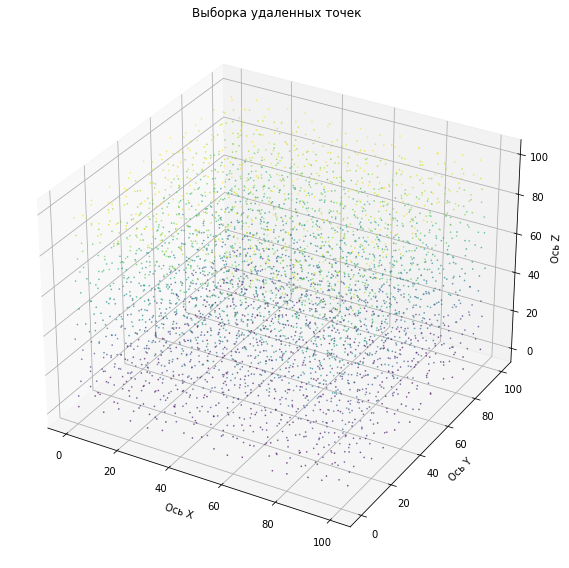


Сравнение производительности методов:
random: 0.007 сек, 10000 точек
voxel: 0.182 сек, 2197 точек
farthest: 23.289 сек, 4096 точек

Обработка завершена!


In [10]:
# Инициализация процессора
processor = PointCloudProcessor()

# Генерация или загрузка облака
cloud_file = pathlib.Path('point_cloud.xyz')

if cloud_file.exists():
    print("Загрузка существующего облака...")
    point_cloud = processor.load_cloud('point_cloud.xyz')
else:
    print("Генерация нового облака...")
    point_cloud = processor.generate_cloud(100000, (0, 100))
    processor.store_cloud(point_cloud, 'point_cloud.xyz')

print(f"Исходное облако: {point_cloud.shape[0]} точек")

# Визуализация исходного облака
processor.visualize_3d(point_cloud, "Исходное облако точек")

# Создание сэмплера
sampler = CloudSampler()

# Применение различных методов прореживания
methods = [
    ("Случайное прореживание", 
     lambda: sampler.stochastic_sample(point_cloud, 10000),
     'sampled_random.xyz'),

    ("Воксельное прореживание", 
     lambda: sampler.voxel_based_sample(point_cloud, 8.0),
     'sampled_voxel.xyz'),

    ("Выборка удаленных точек", 
     lambda: sampler.iterative_farthest_sample(point_cloud, 4096),
     'sampled_farthest.xyz')
]

# Обработка и визуализация результатов
for method_name, sampling_func, output_file in methods:
    print(f"\n{method_name}:")

    start = time.perf_counter()
    sampled_points = sampling_func()
    elapsed = time.perf_counter() - start

    print(f"  Время: {elapsed:.3f} сек")
    print(f"  Результат: {sampled_points.shape[0]} точек")

    processor.store_cloud(sampled_points, output_file)
    processor.visualize_3d(sampled_points, method_name)

# Бенчмаркинг
print("\n" + "="*50)
print("Сравнение производительности методов:")

benchmark_results = benchmark_samplers(point_cloud)

for method, data in benchmark_results.items():
    print(f"{method}: {data['time']:.3f} сек, "
          f"{data['points']} точек")

print("\nОбработка завершена!")